## Exploratory Geographical Analysis of BOLD Data for Order Carnivora

We want to learn how the Carnivora family is distributed throughout the world, both in terms of the physical distribution of the specimens that were recorded in the BOLD database, and also how these physical distributions correspond to their BINs. We want to analyze, using clustering and hierarchical trees, if the geographical distribution of the specimens corresponds well with the genetic differences - whether or not theres a strong link between genetic differences based on COI-5P and geographical location for this order. This will be a mostly exploratory analysis, as we don't know how the data looks. Further, if we don't find any indication of a strong link, we can explore cluster groupings to see if there's any interesting patterns. 

Lets begin by loading some necessary R libraries.

In [ ]:
library(vegan)
library(iNEXT)
library(ape)
library(Biostrings)
library(tidyverse)
library(maps)
library(muscle)
library(DECIPHER)
library(Biostrings)
library(dendextend)

Now we can download the combined BOLD data for this order using the BOLD API.

In [ ]:
carnivores <- read_tsv("http://www.boldsystems.org/index.php/API_Public/combined?taxon=Carnivora&format=tsv")

Lets peek at the data using some familiar tools.

In [ ]:
dim(carnivores)
summary(carnivores)

So we have 4451 observations and 80 descriptive factors for those observations. We're most interested in the location columns (lat and lon), the bin_uri column, and the nucleotides column.

Lets determine if we have any duplicates based on bin_uri.

In [ ]:
duplicates <- duplicated(carnivores$bin_uri)
sum(duplicates)

From here we can see we have 4271 duplicates. Now this becomes tricky, how are we supposed to preserve geographical location data? Which one of the bin_uris do we preserve? 

We can determine if we have any missing values for bin_uri, lat, lon, and nucleotides.

In [6]:
primary_cols=list('bin_uri','lat','lon','nucleotides')

for (i in primary_cols) {
 print(i)
 print(sum(is.na(carnivores[[i]])))
}

[1] "bin_uri"
[1] 707
[1] "lat"
[1] 4008
[1] "lon"
[1] 4008
[1] "nucleotides"
[1] 24


There are 4000 missing lat and lon values! That's most of our dataset in fact. Can we salvage this? Lets start by removing the missing lat/lon rows.

In [ ]:
carnivores2 <- carnivores[!is.na(carnivores$lat),]
carnivores3 <- carnivores2[!is.na(carnivores2$lon),]
dim(carnivores3)

We still have 451 observations, not bad. We have to keep in mind our analysis will now be biased towards these observations, as have just removed 4000 records. Now how many of these have NA for bin_uri and/or nucleotides?

In [8]:
primary_cols=list('bin_uri','lat','lon','nucleotides')

for (i in primary_cols) {
  print(i)
  print(sum(is.na(carnivores3[[i]])))
}

[1] "bin_uri"
[1] 74
[1] "lat"
[1] 0
[1] "lon"
[1] 0
[1] "nucleotides"
[1] 16


Okay so only 74 have NA for bin_uri and 16 for nucleotides. Lets get rid of these. 

In [ ]:
carnivores4 <- carnivores3[!is.na(carnivores3$bin_uri),]
carnivores5 <- carnivores4[!is.na(carnivores4$nucleotides),]
dim(carnivores5)

So we have 377 observations left. Now we're back at the question of how to handle the duplicate bin_uris. Lets check how many duplicates we have.

In [ ]:
sum(duplicated(carnivores5$bin_uri))
length(unique(carnivores5$bin_uri))

We have 306 duplicated bin_uris, and 71 unique bin_uris. Before we think of how to handle this, lets plot these records on a world map.

We can use ggplot2 to create a world map and add our lat and lon points. We'll label them based on bin_uri.

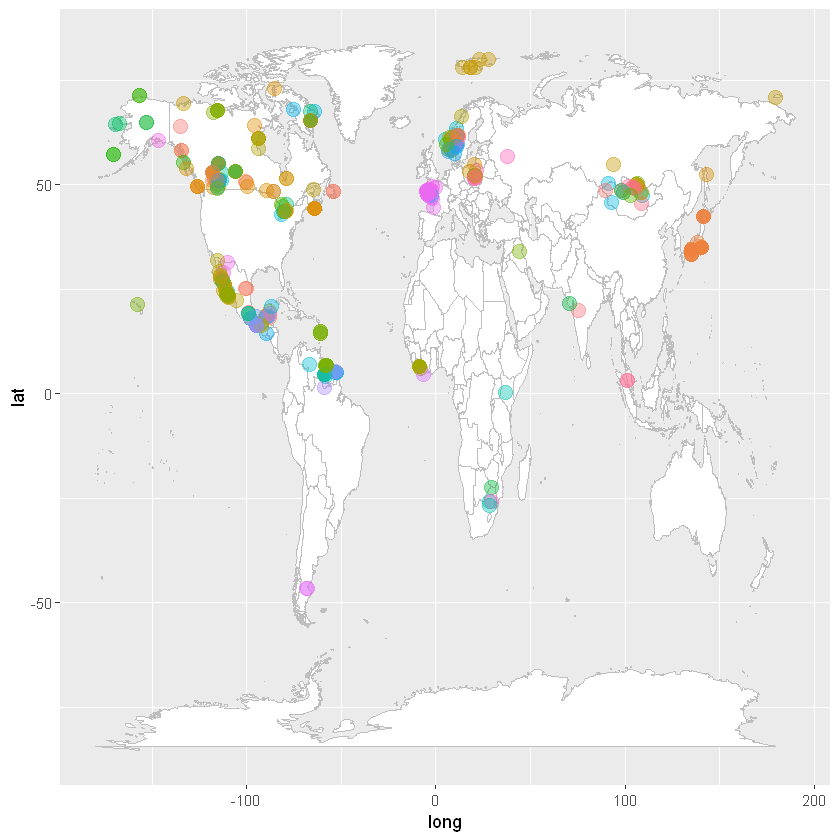

In [11]:
worldmap <- borders("world", colour="Gray", fill="White") 
basemap <- ggplot() +  worldmap

map_data <- 
  basemap +
  geom_point(data=carnivores5, 
             aes(x=lon, y=lat), size=4, alpha=I(0.4)) +aes(color=bin_uri) +guides(color=FALSE)

map_data

Looks like to we have a very spread out geographical distribution, as expected, with high concentrations of samples from North America and Europe. 

Do we have the same number of unique species as the number of unique BINs? 

In [ ]:
length(unique(carnivores5$bin_uri))
length(unique(carnivores5$species_name))

There are 51 Unique species and 71 unique BINs. This means that some of the species might not have been identified and some might be duplicated in two or more BINs. We want to carry out our analysis using the BINs and not the species, since we are only concerned with genetic differences based on geographical location. 

Lets check to see what markercodes have been used for these records

In [13]:
dplyr::count(carnivores5,markercode)

markercode,n
atp6,5
COI-5P,357
COII,5
COXIII,5
CYTB,5


Almost all of the markercodes are COI-5P. Since we want to analyze genetic distance based off COI-5p, lets remove records with the other markercodes. After we can check if we still have 71 unique BINs.

In [ ]:
carnivores6 <- dplyr::filter(carnivores5,markercode=='COI-5P')

length(unique(carnivores6$bin_uri))

Indeed we do still have 71 unique BINs. We can overcome the duplicated bin_uri problem by averaging the lat/lon locations for a given BIN. We might get some funny locations, but we are only concerned with how location is related to genetic distance, so this is fine for the purposes of our analysis. Now lets extract our unique bins, the averaged lat/lon data for those BINS, and the nucleotide data.

We can use the aggregate function to group the records by bin_uri and average and lat and lon columns.

In [ ]:
which(colnames(carnivores6)=='lat')
which(colnames(carnivores6)=='lon')

carnivores_agg <- aggregate(carnivores6[,47:48], list(carnivores6$bin_uri), mean)

Now we have the mean lat/lon values for the unique BINs. Lets remove the dulpicated BINs from our original dataframe. Also lets drop our old lat/lon columns.

In [16]:
carnivores7 <- dplyr::distinct(carnivores6, bin_uri, .keep_all=TRUE)
carnivores8 <- within(carnivores7, rm('lat','lon'))

colnames(carnivores_agg)[1] <- "bin_uri"

Now lets join our two dataframes using the inner join function from tidyverse

In [17]:
carnivores9 <- dplyr::inner_join(carnivores8, carnivores_agg, by= "bin_uri")

Lets see how these BINs are distributed geographically based on the averaged lat/lon values

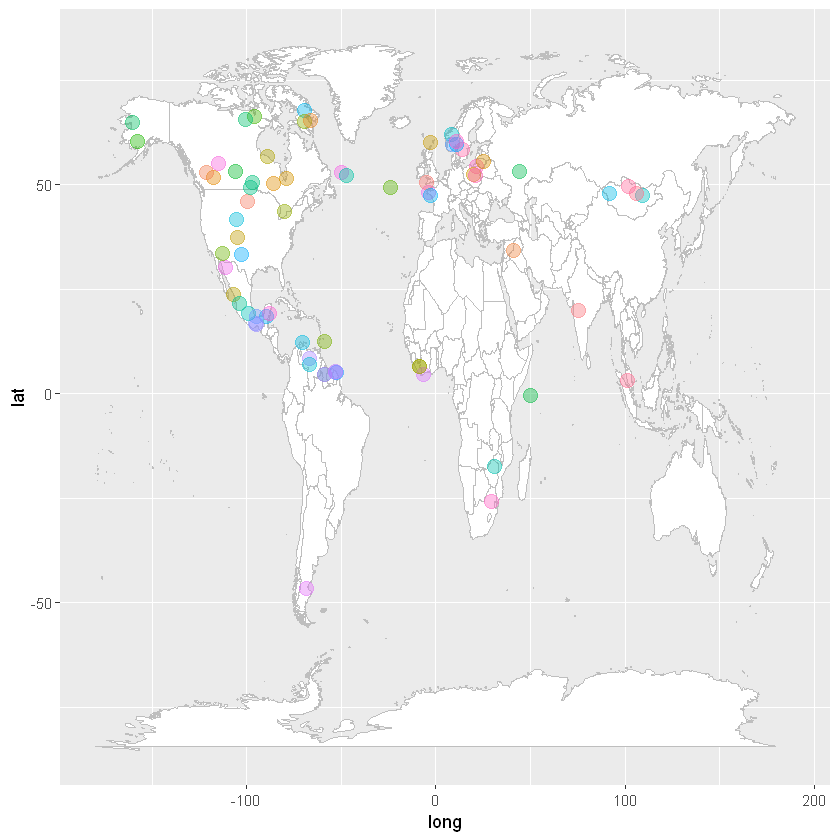

In [18]:
map_data <- 
  basemap +
  geom_point(data=carnivores9, aes(x=lon, y=lat), size=4, alpha=I(0.4)) +
  aes(color=bin_uri) + guides(color=FALSE)
map_data

So as expected we definitely do have some funny locations, but for the most part we have a fairly acceptable geographical distribution of our BINs. Now lets get to our analysis - we're interested in determining the genetic distance based on the COI-5P barcode region for these BINs. 

Lets convert the nucleotide sequences to DNAStringSet type and use the muscle library to do the alignment. We'll also need to convert the DNAStringSet type to DNABin to get the distance matrix.

In [19]:
carnivores9$DNA_SS <- DNAStringSet(carnivores9$nucleotides)

carnivores_aligned <- DNAStringSet(muscle(carnivores9$DNA_SS))

names(carnivores_aligned) <- carnivores9$bin_uri

carnivores_dnabin <- as.DNAbin(carnivores_aligned)


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

file47387a8b1530 71 seqs, max length 723, avg  length 653
1807 MB(21%)00:00:00                Iter   1  100.00%  K-mer dist pass 1
1807 MB(21%)00:00:00                Iter   1  100.00%  K-mer dist pass 2
2115 MB(25%)00:00:00                Iter   1  100.00%  Align node
2115 MB(25%)00:00:00                Iter   1  100.00%  Root alignment
2115 MB(25%)00:00:00                Iter   2  100.00%  Refine tree
2121 MB(25%)00:00:00                Iter   2  100.00%  Root alignment
2121 MB(25%)00:00:00                Iter   2  100.00%  Root alignment
2121 MB(25%)00:00:02                Iter   3  100.00%  Refine biparts
2121 MB(25%)00:00:03                Iter   4  100.00%  Refine biparts


Now we can use the dist.dna() function to compute the distance matrix for the given nucleotide dnabins

In [20]:
distanceMatrix <- dist.dna(carnivores_dnabin, model = "N", as.matrix = TRUE, 
                           pairwise.deletion = TRUE)

Lets use spantree() from the vegan library to get an idea of how differentiated our dataset is in terms of distance

Initial stress        : 0.31024
stress after  10 iters: 0.15345, magic = 0.461
stress after  20 iters: 0.10077, magic = 0.213
stress after  30 iters: 0.08625, magic = 0.098
stress after  40 iters: 0.07754, magic = 0.500
stress after  50 iters: 0.07443, magic = 0.500
stress after  60 iters: 0.07384, magic = 0.500
stress after  70 iters: 0.07368, magic = 0.500
stress after  80 iters: 0.07358, magic = 0.500
stress after  90 iters: 0.07354, magic = 0.500


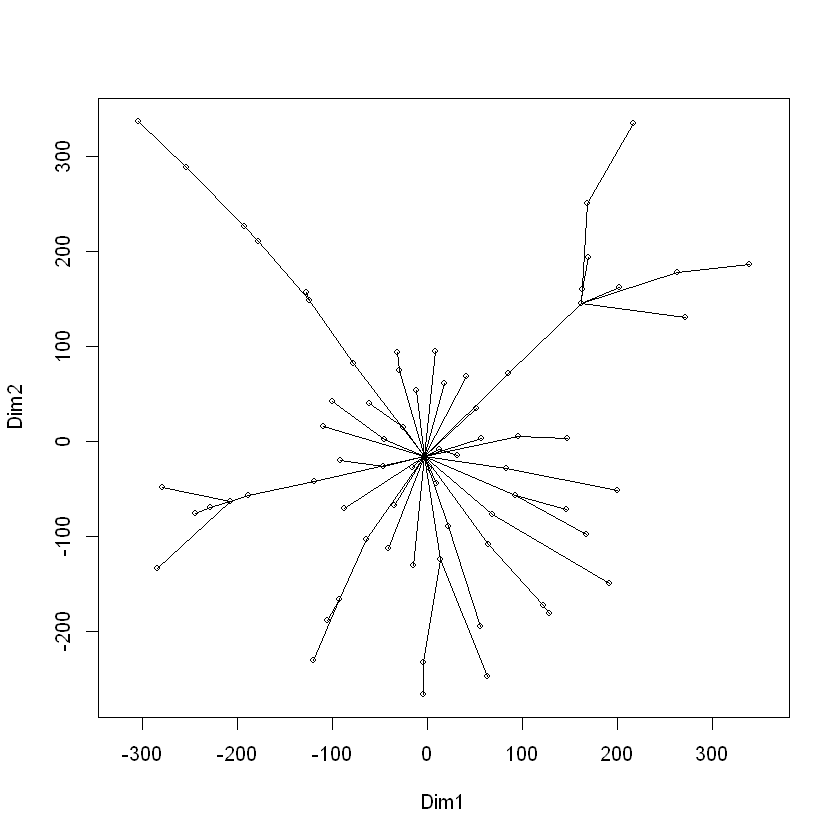

In [22]:
plot(spantree(distanceMatrix))

So it looks like we have a lot of interrelated specimens, but the bottom left, top left, and top right branching indicates that there are some very differentiated groups within this dataset, which could lead to some interesting clustering results.

Lets use hclust() and UPGMA based clustering to generate a dendogram for these BINs. Hierarchical clustering is not a bad option here as we know there is a strong phylogenetic relationship between the specimens.

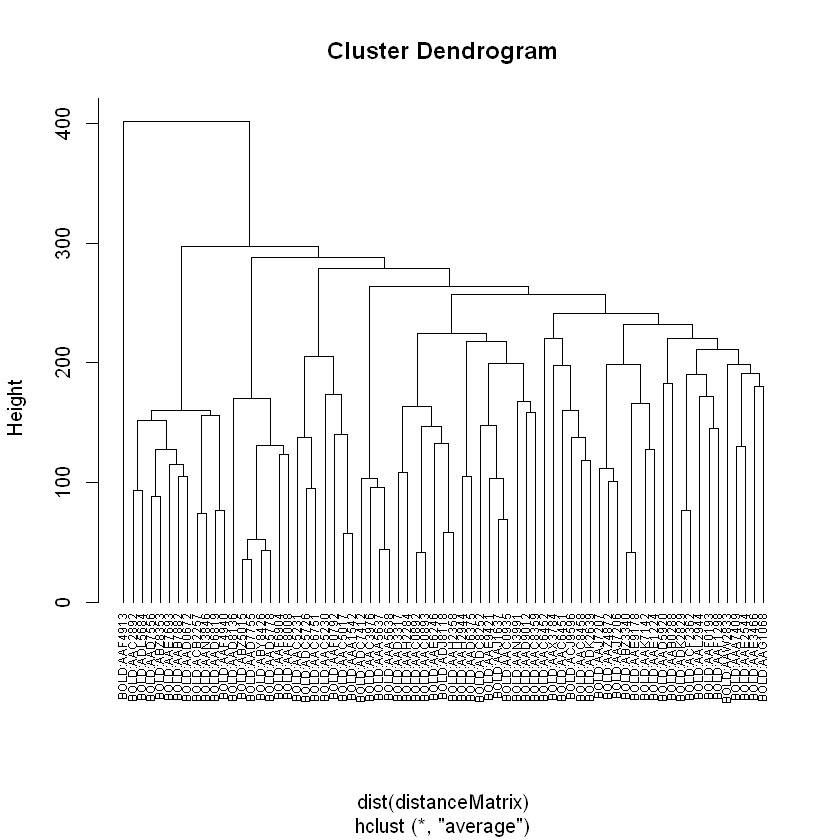

In [23]:
carnivore_clus <- hclust(dist(distanceMatrix), method='average')

plot(carnivore_clus, hang = -1, cex = 0.6)

We have an interesting dendrogram for our data. Lets use a few different values for k (the number of desired clusters) for our tree and label our BINs accordingly. Then we can begin to analyze geographical patterns based on the clustering.

In [ ]:
cut_k4 <- list(cutree(carnivore_clus, k=4))
cut_k6 <- list(cutree(carnivore_clus, k=6))
cut_k8 <- list(cutree(carnivore_clus, k=8))

carnivores10 <- cbind(carnivores9, cut_k4,cut_k6,cut_k8)

dim(carnivores10)
colnames(carnivores10)[82:84] <- c("k4","k6","k8")

carnivores_final <- subset(carnivores10, select=c(bin_uri, species_name, genus_name, family_name, processid, associated_taxa, lat,lon, k4, k6, k8))

Great! Now we can begin to examine our data and how our clustering matches up with the geographical data. Lets start with k4, which led to four clusters being created.  

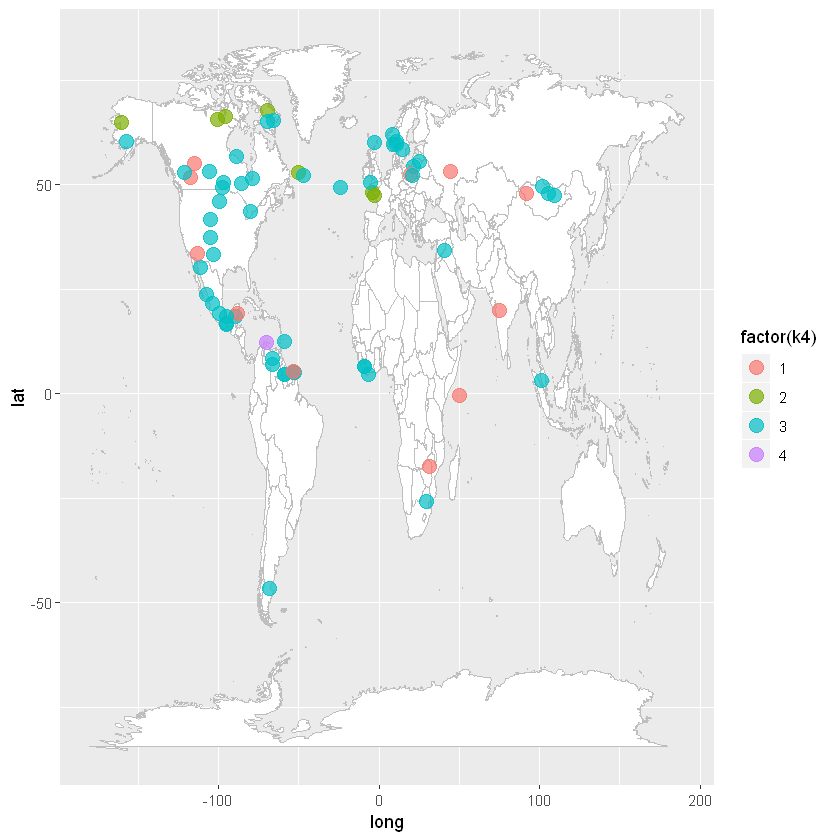

In [25]:
map_data <- 
  basemap +
  geom_point(data=carnivores_final, 
             aes(x=lon, y=lat), size=4, alpha=I(0.7)) +
  aes(color=factor(k4))

map_data

We can definitely see some geographical patterns, such as the very high concentration of cluster 3 in North America and Europe. However we don't have enough clusters to make any real inferences here, so lets move onto k=6.

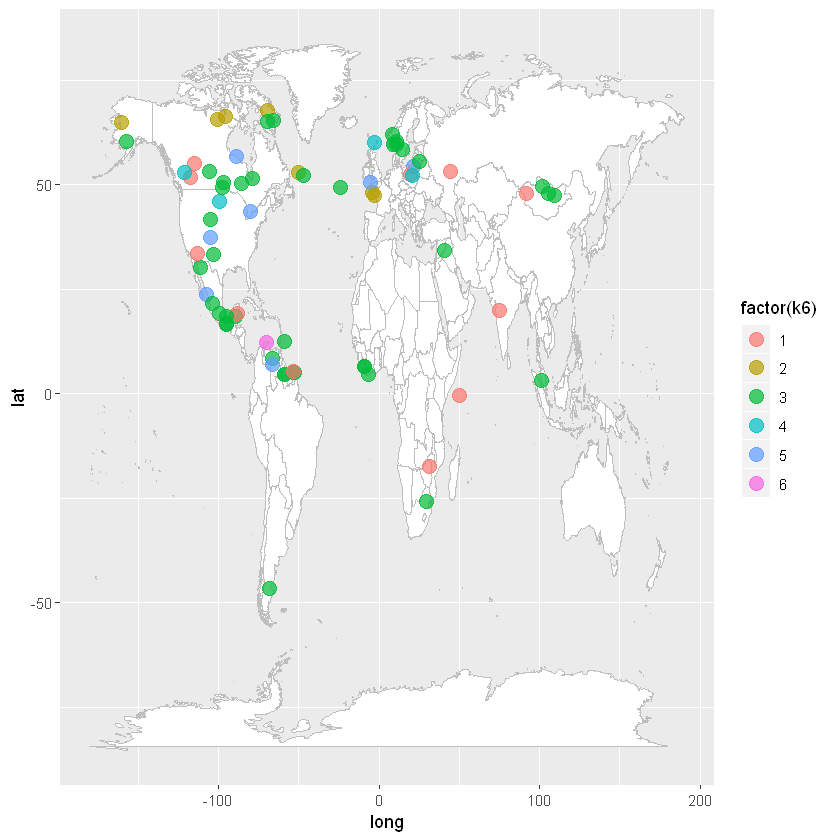

In [26]:
map_data <- 
  basemap +
  geom_point(data=carnivores_final, 
             aes(x=lon, y=lat), size=4, alpha=I(0.7)) +
  aes(color=factor(k6))

map_data

We can see a grouping of cluster 3 in Sweden and Norway. This might be interesting to analyze. Cluster 3 dominates North America, but is also very spread out. Cluster 1 is spotty across various locations. Cluster 6 only has one member from what we can tell, it might be worth looking at this member as it seems to be very different from the rest. Cluster 2 has members in North America and Europe, but what's interesting is that it's members are biased towards Northern latitudes, perhaps indicating genetic differentiation due to climate conditions. Cluster 4 has a few members in North America and Europe, and cluster 5 is unremarkable. Lets finally do a plot of k=8.

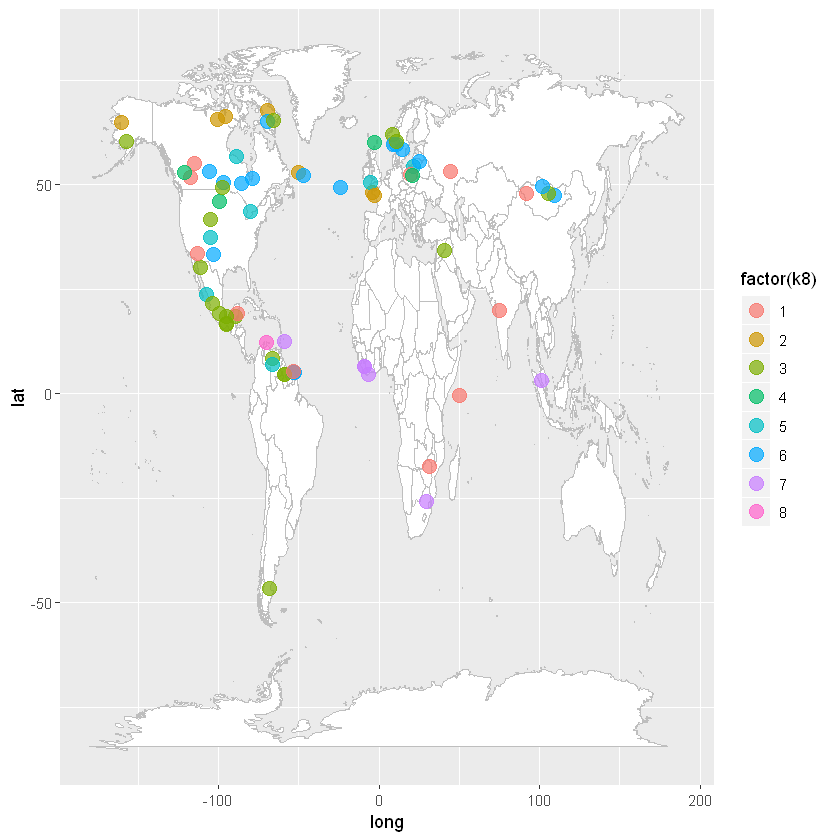

In [27]:
map_data <- 
  basemap +
  geom_point(data=carnivores_final, 
             aes(x=lon, y=lat), size=4, alpha=I(0.7)) +
  aes(color=factor(k8))

map_data

We actually seem to lose some patterns when doing k=8, indicating we might have too many clusters. However, the sole member at the top of South America (cluster 8) still persisted. Lets find out more about this record.

In [28]:
carnivores_solomember <- filter(carnivores_final, k8==8)

carnivores_solomember

bin_uri,species_name,genus_name,family_name,processid,associated_taxa,lat,lon,k4,k6,k8
BOLD:AAF4913,NA,NA,NA,MYPMX102-10,NA,12.37625,-70.37575,4,6,8


Interesting, this may be an unidentified member of the carnivora order. Only order is specified for this record, as there is no species, genus, or family name assigned. It's very different from other carnivora members in this dataset, so might it be a misidentification? Follow up would be necessary.

We had a persistent grouping for k=4 and k=6 for datapoints near Norway and Sweden. The grouping still somewhat persisted for k=8. Lets take a closer look.

The coordinates that contain these points are roughly: Lat(55,67) and Lon(4,20). So we can subset our data to look a bit more closely at these BINs.

In [30]:
carnivores_filtered <- filter(carnivores_final, lat<67 & lat>55 & lon>4 & lon<20)

carnivores_filtered

bin_uri,species_name,genus_name,family_name,processid,associated_taxa,lat,lon,k4,k6,k8
BOLD:AAF0193,Lutra lutra,Lutra,Mustelidae,NOMAM092-09,NA,62.16810,8.098100,3,3,3
BOLD:AAJ1637,Martes martes,Martes,Mustelidae,NOMAM085-09,NA,59.56253,9.013753,3,3,6
BOLD:ADC8252,Martes martes,Martes,Mustelidae,GBMIN41871-14,NA,58.35567,14.305933,3,3,6
BOLD:AAH2358,Mustela putorius,Mustela,Mustelidae,NOMAM168-17,NA,59.54755,10.836717,3,3,6
BOLD:ACF2362,Meles meles,Meles,Mustelidae,NOMAM162-17,NA,60.40300,11.129700,3,3,3


All of these five Carnivora order members come from the same family, which is Mustelidae. We seem to have a duplicate species for the two bins for Martes martes. The two Martes martes samples clustered along with the Mustela member in k8, whereas the Lutra and Meles members clustered seperately. What genetic distance did we get between the two Martes martes samples?

In [ ]:
distanceMatrix['BOLD:AAJ1637','BOLD:ADC8252']

So we got a value of 15, which is very small for the genetic distance between the two BINs. However it could still indicate a significant degree of difference, but further investigation would be necessary. 

Overall, we did find some geographical patterns for the data from unique BINs, but there was no clear link for most of the clusters. It must be taken into consideration that we had to remove 4000 records because they had missing lat/lon data, so the analysis was severely affected because of this. However, it may also have not been possible to do clustering analysis with a significantly greater number of unique bins. A more robust analysis for geographical location and genetic distance would involve more quantitative measures for geographical seperation of clusters, such as distance measurement based on lat/lon of average geographical location of clusters. 